## Import modules

In [1]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import gc
import joblib # Use to save model
from datetime import datetime, timezone
sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [3]:
ROOT  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_23T22_14_L001_r_0_1_grid_0_02_features.npz"""
ROOT_2  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_23T23_39_L001_r_0_2_grid_0_04_features.npz"""
ROOT_3  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_24T05_30_L001_r_0_4_grid_0_08_features.npz"""
ROOT_4  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_24T11_50_L001_r_0_8_grid_0_16_features.npz"""
ROOT_5  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_24T12_27_L001_r_1_6_grid_0_32_features.npz"""
ROOT_6 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_24T20_28_L001_r_3_2_grid_0_64_features.npz"""
# ROOT_7 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T00_29_L001_r_6_4_grid_1_28_features.npz"""
# ROOT_8 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T01_37_L001_r_12_8_grid_2_56_features.npz"""


In [4]:
fileList = [ROOT,ROOT_2, ROOT_3,ROOT_4,ROOT_5, ROOT_6]

## Get computed features

In [5]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

## Load in points and labels

In [6]:
xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

## Combine road markings with Ground points

In [7]:
cls[cls==2] = 1

In [8]:
cls[cls > 1] -= 1

## Get columns

In [9]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","count"]

In [10]:
# cols1 = [f"""{a}_radius1""" for a in cols]
# cols2 = [f"""{a}_radius2""" for a in cols]
ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
    

# allCols = cols1 + cols2
    
    
    

In [11]:
allCols = ['X', 'Y','Z'] + ff + ['label']

In [12]:
allAtrs = np.hstack((xyz,das, cls.reshape(-1, 1)))

## Create dataframe

In [13]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols)
total_dataframe["label"] = total_dataframe["label"].astype(int)
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype(int)
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [14]:
total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
total_dataframe = total_dataframe.copy()

In [15]:
gc.collect()

23

In [16]:
# ss = ss[ss["count"] > 10]

## Create PLY files with features (Only do if they don't already exist)

In [17]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L001_features_radius{i}.ply""")

## Instantiate Random Forest classifier

In [18]:
rf = RandomForestClassifier(verbose=1, n_jobs=8)

In [19]:
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
total_dataframe.reset_index(inplace = True)

### Take random samples of labels for training data

In [22]:
maxAcc = 0.0

AccList = [maxAcc]

AccDelta = 1e-4

difDelta = np.inf


randomState = 123
sampleSize = 1000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,8):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)

    difDelta = np.abs(maxAcc - acc)

    print("""\n\nCurrent accuracy delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = acc
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   

    
    
    
    
    # print(total_dataframe.loc[total_dataframe["label"] == i].shape[0])

Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   36.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.1s finished


Current accuracy: 94.4992


Current accuracy delta: 0.94499
Starting iteration 2...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   38.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.4s finished


Current accuracy: 95.3245


Current accuracy delta: 0.00825
Starting iteration 3...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   38.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.6s finished


Current accuracy: 95.9135


Current accuracy delta: 0.00589
Starting iteration 4...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.7s finished


Current accuracy: 96.1265


Current accuracy delta: 0.00213
Starting iteration 5...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   42.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.1s finished


Current accuracy: 96.3254


Current accuracy delta: 0.00199
Starting iteration 6...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.0s finished


Current accuracy: 96.5066


Current accuracy delta: 0.00181
Starting iteration 7...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   42.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.3s finished


Current accuracy: 96.6658


Current accuracy delta: 0.00159
Starting iteration 8...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   41.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.0s finished


Current accuracy: 96.8036


Current accuracy delta: 0.00138
Starting iteration 9...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   43.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.4s finished


Current accuracy: 96.9010


Current accuracy delta: 0.00097
Starting iteration 10...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   43.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.9s finished


Current accuracy: 97.0168


Current accuracy delta: 0.00116
Starting iteration 11...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   42.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.5s finished


Current accuracy: 97.0831


Current accuracy delta: 0.00066
Starting iteration 12...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   41.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.7s finished


Current accuracy: 97.1832


Current accuracy delta: 0.00100
Starting iteration 13...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   44.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished


Current accuracy: 97.2646


Current accuracy delta: 0.00081
Starting iteration 14...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   44.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.7s finished


Current accuracy: 97.2693


Current accuracy delta: 0.00005
DONE!!!!


In [23]:
gc.collect()

0

## Plot iterations and accuracy

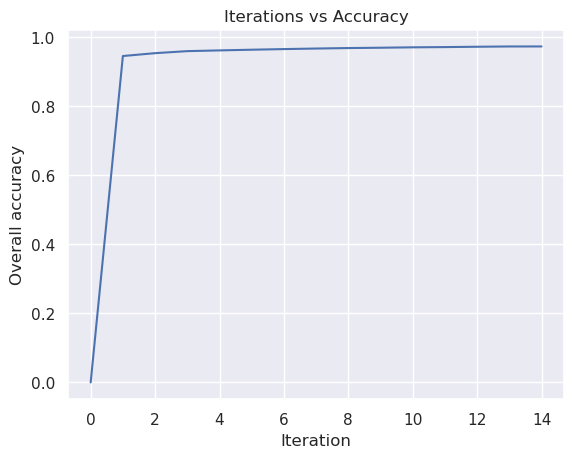

In [24]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [25]:
OUTS = f"""{datetime.now(timezone.utc).strftime("%Y_%m_%dT%H_%M")}_L001Trained_RF.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_10_30T03_32_L001Trained_RF.joblib']